In [56]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# supernovae_lst = pd.read_csv("./TESS_data/sn_count_transients_s1-47 (4).txt")
transients = pd.read_csv("./TESS_data/AT_count_transients_s1-47 (4).txt", names=["sector", "ra", "dec", "mag", "TJD_discovery", "type" ,"class", "IAU", "survey", "cam", "ccd", "col", "row"], delim_whitespace=True)
transients

,sector,ra,dec,mag,TJD_discovery,type,class,IAU,survey,cam,ccd,col,row
0,1,327.160083,-43.380019,17.800,1340.340,SN,SNIa,2018evo,ASAS-SN,1,1,1860.105,322.643
1,1,315.033417,-40.358594,17.869,1341.926,SN,SNIa,2018exc,ATLAS,1,1,528.652,1304.728
2,1,313.474583,-38.015594,18.781,1347.901,SN,SNII,2018fgb,ATLAS,1,1,424.192,1751.547
3,1,332.648000,-27.250161,16.700,1331.630,SN,SNII,2018emt,ASAS-SN,1,3,642.568,1607.839
4,1,327.584333,-26.300131,19.405,1337.965,AT,Unclassified,2018esp,ATLAS,1,3,1303.439,1157.924
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398,47,167.461817,75.334383,20.670,2601.001,AT,Unclassified,2022aji,Pan-STARRS1,3,2,521.417,1084.865
4399,47,210.216792,78.085778,19.680,2601.143,AT,Unclassified,2022aha,Pan-STARRS1,3,3,1679.425,1415.721
4400,47,300.459933,85.849581,18.075,2588.733,AT,Unclassified,2022gn,ATLAS,3,4,1667.608,986.600
4401,47,256.141083,76.155150,18.470,2589.662,AT,Unclassified,2022op,GaiaAlerts,4,1,1990.840,279.007


In [57]:
light_curves = os.listdir("./TESS_data/light_curves_fausnaugh")
# name = light_curves[random.randint(0, len(light_curves)-1)]
# print(light_curves[i])
filename = "lc_2018eel_cleaned"
curve = pd.read_csv("./TESS_data/light_curves_fausnaugh/" + filename, delim_whitespace=True)

#read AT_count file to find nonlight curve data of transient
curve_name = filename.split("_")[1]
curve_meta = transients[transients['IAU'] == curve_name]
display(curve_meta)

,sector,ra,dec,mag,TJD_discovery,type,class,IAU,survey,cam,ccd,col,row
21,1,349.797208,-66.677069,18.89,1325.07899,AT,Unclassified,2018eel,GaiaAlerts,3,2,349.347,109.321


In [58]:
curve['relative_time'] = curve['TJD'] - curve_meta["TJD_discovery"].iloc[0]
curve.index = pd.TimedeltaIndex(curve['relative_time'], unit="D")
plot_title = f"{curve_name}\n Class: {curve_meta['class'].iloc[0]}, Sector: {curve_meta['sector'].iloc[0]} \nCoords:{curve_meta['ra'].iloc[0], curve_meta['dec'].iloc[0]}, \nDiscovery TJD: {curve_meta['TJD_discovery'].iloc[0]}, Survey: {curve_meta['survey'].iloc[0]}"

def display_curve(col, error):
    return curve.plot.scatter(x="relative_time", y=col, c="00000", alpha=0.5, yerr=curve[error], ylabel="Flux", xlabel="Days relative to discovery", title=plot_title)

# Preprocessing steps
## 1. Sigma Clipping: remove points with flux uncertainties more than 3 sigma from mean uncertainty, repeat clipping 5 times

<AxesSubplot:title={'center':'2018eel\n Class: Unclassified, Sector: 1 \nCoords:(349.79720833, -66.67706944), \nDiscovery TJD: 1325.07899, Survey: GaiaAlerts'}, xlabel='Days relative to discovery', ylabel='Flux'>

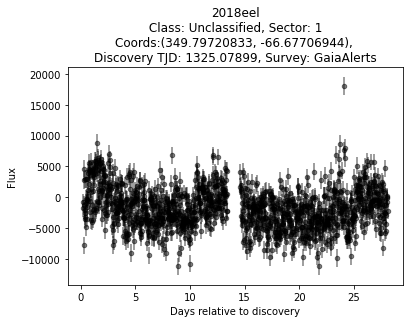

In [59]:

for _ in range(0, 5):
    uncert_mean = curve.e_cts.mean()
    threshold = 3*curve.e_cts.std()
    curve = curve[np.abs(curve['e_cts'] - uncert_mean) <= threshold]

display_curve("cts", "e_cts")

## 2. Subtract background Flux

<AxesSubplot:title={'center':'2018eel\n Class: Unclassified, Sector: 1 \nCoords:(349.79720833, -66.67706944), \nDiscovery TJD: 1325.07899, Survey: GaiaAlerts'}, xlabel='Days relative to discovery', ylabel='Flux'>

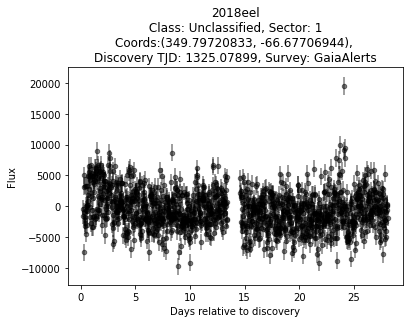

In [60]:
curve['no_bkg_cts'] = curve['cts'] - curve['bkg_model']
display_curve('no_bkg_cts', "e_cts")

## 3. Correct for milky way extinction using Fitzpatrick Reddening function
Wavelength of TESS bandpass is between 600-1000nm, central wavelength is 786.5nm

<AxesSubplot:title={'center':'2018eel\n Class: Unclassified, Sector: 1 \nCoords:(349.79720833, -66.67706944), \nDiscovery TJD: 1325.07899, Survey: GaiaAlerts'}, xlabel='Days relative to discovery', ylabel='Flux'>

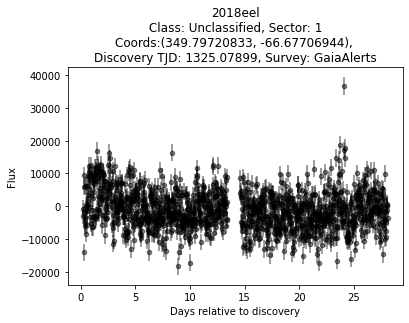

In [61]:
import extinction
from astroquery.irsa_dust import IrsaDust
import astropy.coordinates as coord
import astropy.units as u

# Set relevant parameters
ra = curve_meta["ra"].iloc[0]
dec = curve_meta["dec"].iloc[0]
flux_in = curve['no_bkg_cts']
fluxerr_in = curve["e_cts"]
bandpass_wavelengths = np.array([786.5,])


# Get Milky Way E(B-V) Extinction
coo = coord.SkyCoord(ra * u.deg, dec * u.deg, frame='icrs')
dust = IrsaDust.get_query_table(coo, section='ebv')
mwebv = dust['ext SandF mean'][0]


# Remove extinction from light curves (Using negative a_v so that extinction.apply works in reverse and removes the extinction)
extinction_per_passband = extinction.fitzpatrick99(wave=bandpass_wavelengths, a_v=-3.1 * mwebv, r_v=3.1, unit='aa')
flux_out = extinction.apply(extinction_per_passband[0], flux_in, inplace=False)
fluxerr_out = extinction.apply(extinction_per_passband[0], fluxerr_in, inplace=False)

curve['unreddened_cts'] = flux_out
curve['unreddened_ects'] = fluxerr_out

display_curve('unreddened_cts', 'unreddened_ects')

## 4. Normalize Data

<AxesSubplot:title={'center':'2018eel\n Class: Unclassified, Sector: 1 \nCoords:(349.79720833, -66.67706944), \nDiscovery TJD: 1325.07899, Survey: GaiaAlerts'}, xlabel='Days relative to discovery', ylabel='Flux'>

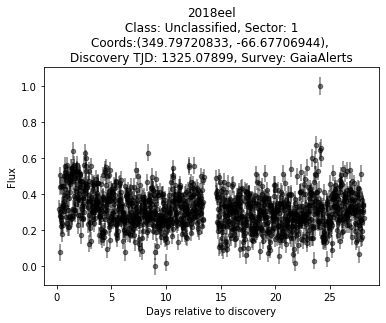

In [62]:
curve['normalized_cts'] = (curve.unreddened_cts - curve.unreddened_cts.min()) / (curve.unreddened_cts.max()-curve.unreddened_cts.min())
curve['normalized_ects'] = curve['unreddened_ects'] / (curve.unreddened_cts.max()-curve.unreddened_cts.min())
# curve.plot.scatter(x="BTJD", y='normalized_cts', c="00000", alpha=0.5, ylabel="Flux", xlabel="Barycentric TESS Julian Date")
display_curve('normalized_cts', 'normalized_ects')

In [63]:
#display all data
curve

,BTJD,TJD,cts,e_cts,bkg,bkg_model,bkg2,e_bkg2,relative_time,no_bkg_cts,unreddened_cts,unreddened_ects,normalized_cts,normalized_ects
relative_time,,,,,,,,,,,,,,
0 days 05:37:07.968000,1325.32686,1325.31311,-787.5803,1360.1774,1207.8812,-385.4021,-3999.6970,1360.1774,0.23412,-402.1782,-755.684349,2555.744624,0.319664,0.046572
0 days 06:07:07.680000,1325.34769,1325.33394,-1777.4286,1369.8893,5788.3438,-286.7154,-385.4021,1369.8893,0.25495,-1490.7132,-2801.018637,2573.993079,0.282393,0.046905
0 days 06:37:07.392000,1325.36853,1325.35477,2774.8904,1376.5653,5447.9537,-385.4021,-0.0470,1376.5653,0.27578,3160.2925,5938.122900,2586.537142,0.441642,0.047133
0 days 07:07:07.968000,1325.38936,1325.37561,-7801.0853,1379.5251,3987.8992,-385.4021,-6249.4372,1379.5251,0.29662,-7415.6832,-13933.912204,2592.098544,0.079523,0.047235
0 days 07:37:07.680000,1325.41019,1325.39644,4628.3823,1384.2670,4151.3676,-385.4021,1492.5527,1384.2670,0.31745,5013.7844,9420.795057,2601.008474,0.505106,0.047397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27 days 23:37:06.240000,1353.07673,1353.06309,149.4070,1352.8877,-405.3396,-285.5262,-1654.5594,1352.8877,27.98410,434.9332,817.230302,2542.047432,0.348327,0.046323
28 days 00:07:06.816000,1353.09757,1353.08393,-852.1686,1353.3167,1779.2645,-268.9502,-1045.2953,1353.3167,28.00494,-583.2184,-1095.855063,2542.853514,0.313465,0.046337
28 days 00:37:06.528000,1353.11840,1353.10476,-180.3790,1353.4989,-814.9086,-285.5262,734.1103,1353.4989,28.02577,105.1472,197.569369,2543.195864,0.337035,0.046343


## 5. Bin Data (may or not be needed)
bins the data into 1 day intervals and takes the mean of each bin

In [64]:
binned = curve.resample("1D").mean()
binned

,BTJD,TJD,cts,e_cts,bkg,bkg_model,bkg2,e_bkg2,relative_time,no_bkg_cts,unreddened_cts,unreddened_ects,normalized_cts,normalized_ects
relative_time,,,,,,,,,,,,,,
0 days 05:37:07.968000,1325.826864,1325.813107,544.957955,1419.076329,6520.285557,-544.947131,-836.327659,1419.076329,0.734117,1089.905086,2047.908650,2666.414468,0.370753,0.048589
1 days 05:37:07.968000,1326.837287,1326.823520,2491.855812,1438.067577,6170.744729,-352.821054,-156.081096,1438.067577,1.744530,2844.676867,5345.087787,2702.098623,0.430836,0.049239
2 days 05:37:07.968000,1327.836387,1327.822614,-76.461626,1414.847357,6037.150628,-1476.642241,-1440.897278,1414.847357,2.743624,1400.180615,2630.909821,2658.468318,0.381377,0.048444
3 days 05:37:07.968000,1328.837299,1328.823520,-1451.338267,1401.815779,3988.201185,-1620.062427,-1828.118435,1401.815779,3.744530,168.724160,317.029136,2633.982260,0.339212,0.047998
4 days 05:37:07.968000,1329.837304,1329.823520,-1711.730379,1394.497719,4540.132852,-1918.819517,-1920.969165,1394.497719,4.744530,207.089137,389.116118,2620.231779,0.340525,0.047747
5 days 05:37:07.968000,1330.858142,1330.844353,-2462.489383,1385.787202,2765.333911,-1590.884470,-1470.572515,1385.787202,5.765363,-871.604913,-1637.727234,2603.864902,0.303591,0.047449
6 days 05:37:07.968000,1331.837311,1331.823520,-2773.928046,1382.652144,2366.855204,-1853.372733,-1999.316573,1382.652144,6.744530,-920.555313,-1729.704001,2597.974193,0.301915,0.047342
7 days 05:37:07.968000,1332.836408,1332.822614,-2874.844765,1385.245930,2310.894570,-1637.303830,-1955.100291,1385.245930,7.743624,-1237.540935,-2325.313295,2602.847864,0.291062,0.047430
8 days 05:37:07.968000,1333.837316,1333.823520,-2198.092831,1385.452877,2759.291687,-1589.340558,-1450.979167,1385.452877,8.744530,-608.752273,-1143.832671,2603.236712,0.312591,0.047438


<AxesSubplot:title={'center':'2018eel\n Class: Unclassified, Sector: 1 \nCoords:(349.79720833, -66.67706944), \nDiscovery TJD: 1325.07899, Survey: GaiaAlerts'}, xlabel='Days relative to discovery', ylabel='Flux'>

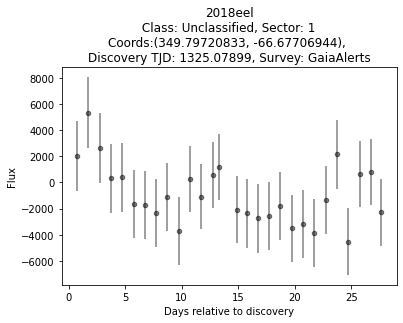

In [65]:
binned.plot.scatter(x="relative_time", y='unreddened_cts', c="00000", alpha=0.5, yerr=binned['unreddened_ects'], ylabel="Flux", xlabel="Days relative to discovery", title=plot_title)

# Find training labels
## 1. Max Light

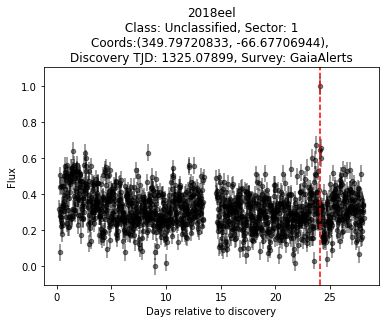

In [66]:
id_max = curve["normalized_cts"].idxmax()
max_data = curve.loc[id_max, :]
t_max = max_data['relative_time']

ax = display_curve('normalized_cts', 'normalized_ects')
ax.axvline(t_max, color="red", linestyle="--")

## 2. Explosion Time